In [21]:
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
torch.manual_seed(0)

In [3]:
from matplotlib.pyplot import imshow 
import matplotlib.pylab as plt
from PIL import Image

In [4]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [7]:
IMAGE_SIZE = 16
transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [9]:
dataset_train = dsets.FashionMNIST(root= '.fashion/data', train=True, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:14<00:00, 1857931.60it/s]


Extracting .fashion/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 124524.97it/s]


Extracting .fashion/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1452180.96it/s]


Extracting .fashion/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to .fashion/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13640099.17it/s]

Extracting .fashion/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to .fashion/data/FashionMNIST/raw



In [10]:
dataset_val = dsets.FashionMNIST(root= '.fashion/data', train=False, transform=transform, download=True)

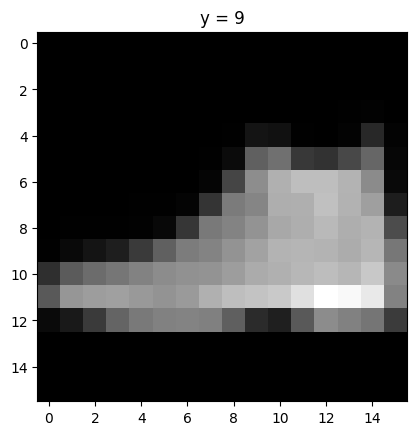

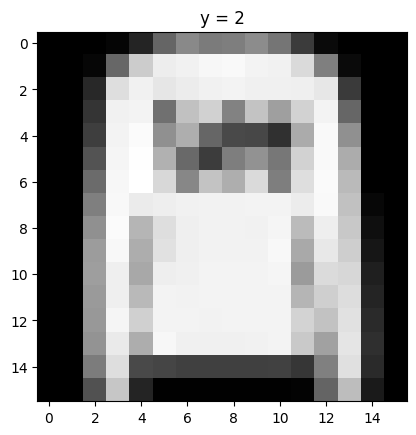

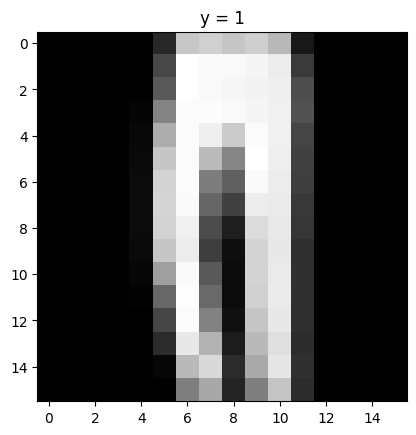

In [17]:
for n, data_sample in enumerate(dataset_val):
    show_data(data_sample)
    plt.show()
    if n == 2:
        break

<span style="font-size:22px;">***- Define Model***.</span>

In [60]:
class CNN_batch(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x
    
model = CNN_batch()

In [61]:
train_loader = DataLoader(dataset=dataset_train, batch_size=100)
val_loader = DataLoader(dataset=dataset_val, batch_size=100)

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)



In [63]:
import torch
torch.cuda.is_available()
device = torch.device('cuda:0')

In [64]:
model.to(device)

CNN_batch(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
  (bn_fc1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [65]:
epochs = 25
train_cost = []
val_cost = []
accuracy_list = []
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        model_output = model(x)
        loss = criterion(model_output, y)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    running_loss = running_loss / len(dataset_train)

    model.eval()
    with torch.no_grad():
        running_val_loss = 0
        correctness = 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            model_output_val = model(x)
            val_loss = criterion(model_output_val, y)
            running_val_loss += val_loss.item()
            quant, prediction = torch.max(model_output_val, 1)
            correctness += (prediction == y).sum().item()

        accuracy = 100 * correctness / len(dataset_val)
        accuracy_list.append(accuracy)

        running_val_loss = running_val_loss / len(dataset_val)

    train_cost.append(running_loss)
    val_cost.append(running_val_loss)
    print("Epoch:", epoch + 1, "Train Loss: ", running_loss, "Val Loss: ", running_val_loss)



Epoch: 1 Train Loss:  0.00503572006324927 Val Loss:  0.004540176779031754
Epoch: 2 Train Loss:  0.0035024010536571343 Val Loss:  0.004123640191555023
Epoch: 3 Train Loss:  0.0031360001196463904 Val Loss:  0.003744789844751358
Epoch: 4 Train Loss:  0.002914973872154951 Val Loss:  0.003636238244175911
Epoch: 5 Train Loss:  0.002744170358777046 Val Loss:  0.0036192037209868432
Epoch: 6 Train Loss:  0.0026119774904102087 Val Loss:  0.0035151301622390746
Epoch: 7 Train Loss:  0.0025013302696247895 Val Loss:  0.003506710061430931
Epoch: 8 Train Loss:  0.0024028516825288534 Val Loss:  0.0033607261657714843
Epoch: 9 Train Loss:  0.0023139654943098624 Val Loss:  0.0033789272785186768
Epoch: 10 Train Loss:  0.002237872158860167 Val Loss:  0.0035452917844057082
Epoch: 11 Train Loss:  0.0021639484112461406 Val Loss:  0.003524719014018774
Epoch: 12 Train Loss:  0.0021049095624436935 Val Loss:  0.0034303166277706624
Epoch: 13 Train Loss:  0.0020365751293798286 Val Loss:  0.0034507330775260924
Epoch:

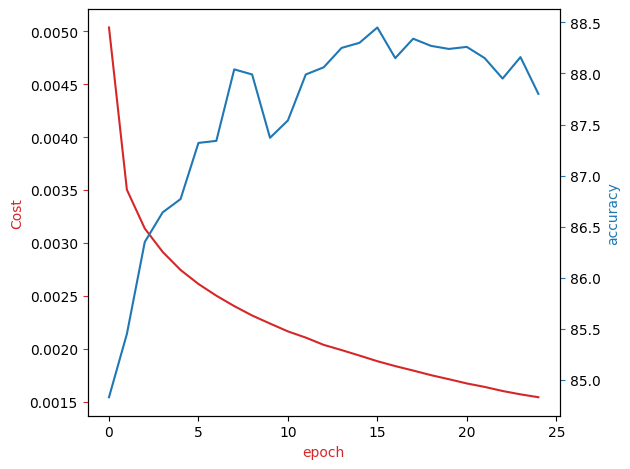

In [66]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()